# Undergraduate Research on Machine Learning

%%html
<p>First step is to find a good preprocessing method that will convert audio into a usuable medium for detail extraction.
</p>
<p>I came across a method that converts audio wav files into spectrograms using a certain Fourier Transform called</br>
STFT(Short Time Fourier Transform). The benefits of this method is that it can create distinct patterns that</br>
one can distinguish the heartbeats from.</p>
<p><center>Here is a short description of the STFT.</center></br>
<strong>STFT breaks the signal into small snippets so that when you take the transform you have an idea of that spectrums locality.

STFT provides the time-localized frequency information for situations in which frequency components of a signal vary over time, 
whereas the standard Fourier transform provides the frequency information averaged over the entire signal time interval.
</strong></p>

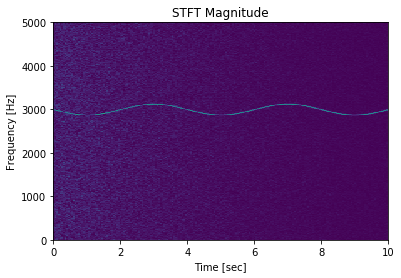

In [303]:
from scipy import signal
import matplotlib.pyplot as plt

fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = np.random.normal(scale=np.sqrt(noise_power),
                          size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise

f, t, Zxx = signal.stft(x, fs, nperseg=1000)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp)
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

/Users/admin/Desktop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


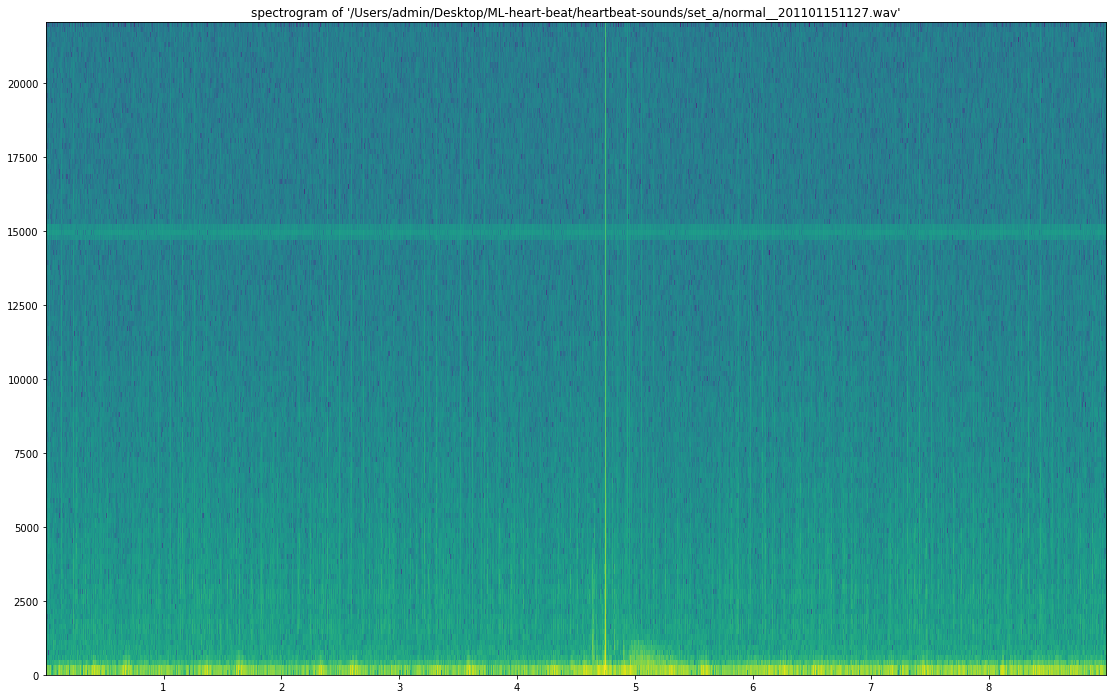

In [2]:
import os
import wave
import numpy as np
import pylab

def graph_spectrogram(wav_file):
    sound_info, frame_rate = get_wav_info(wav_file)
    pylab.figure(num=None, figsize=(19, 12))
    pylab.subplot(111)
    pylab.title('spectrogram of %r' % wav_file)
    pylab.specgram(sound_info, Fs=frame_rate)
    pylab.savefig('spectrogram.png')
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.fromstring(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

graph_spectrogram('/Users/admin/Desktop/ML-heart-beat/heartbeat-sounds/set_a/normal__201101151127.wav')

<p>After finding some code that worked, I was able to convert it into logarithmic scale. Sadly, there wasn't much
detail that could extracted from it.</p>

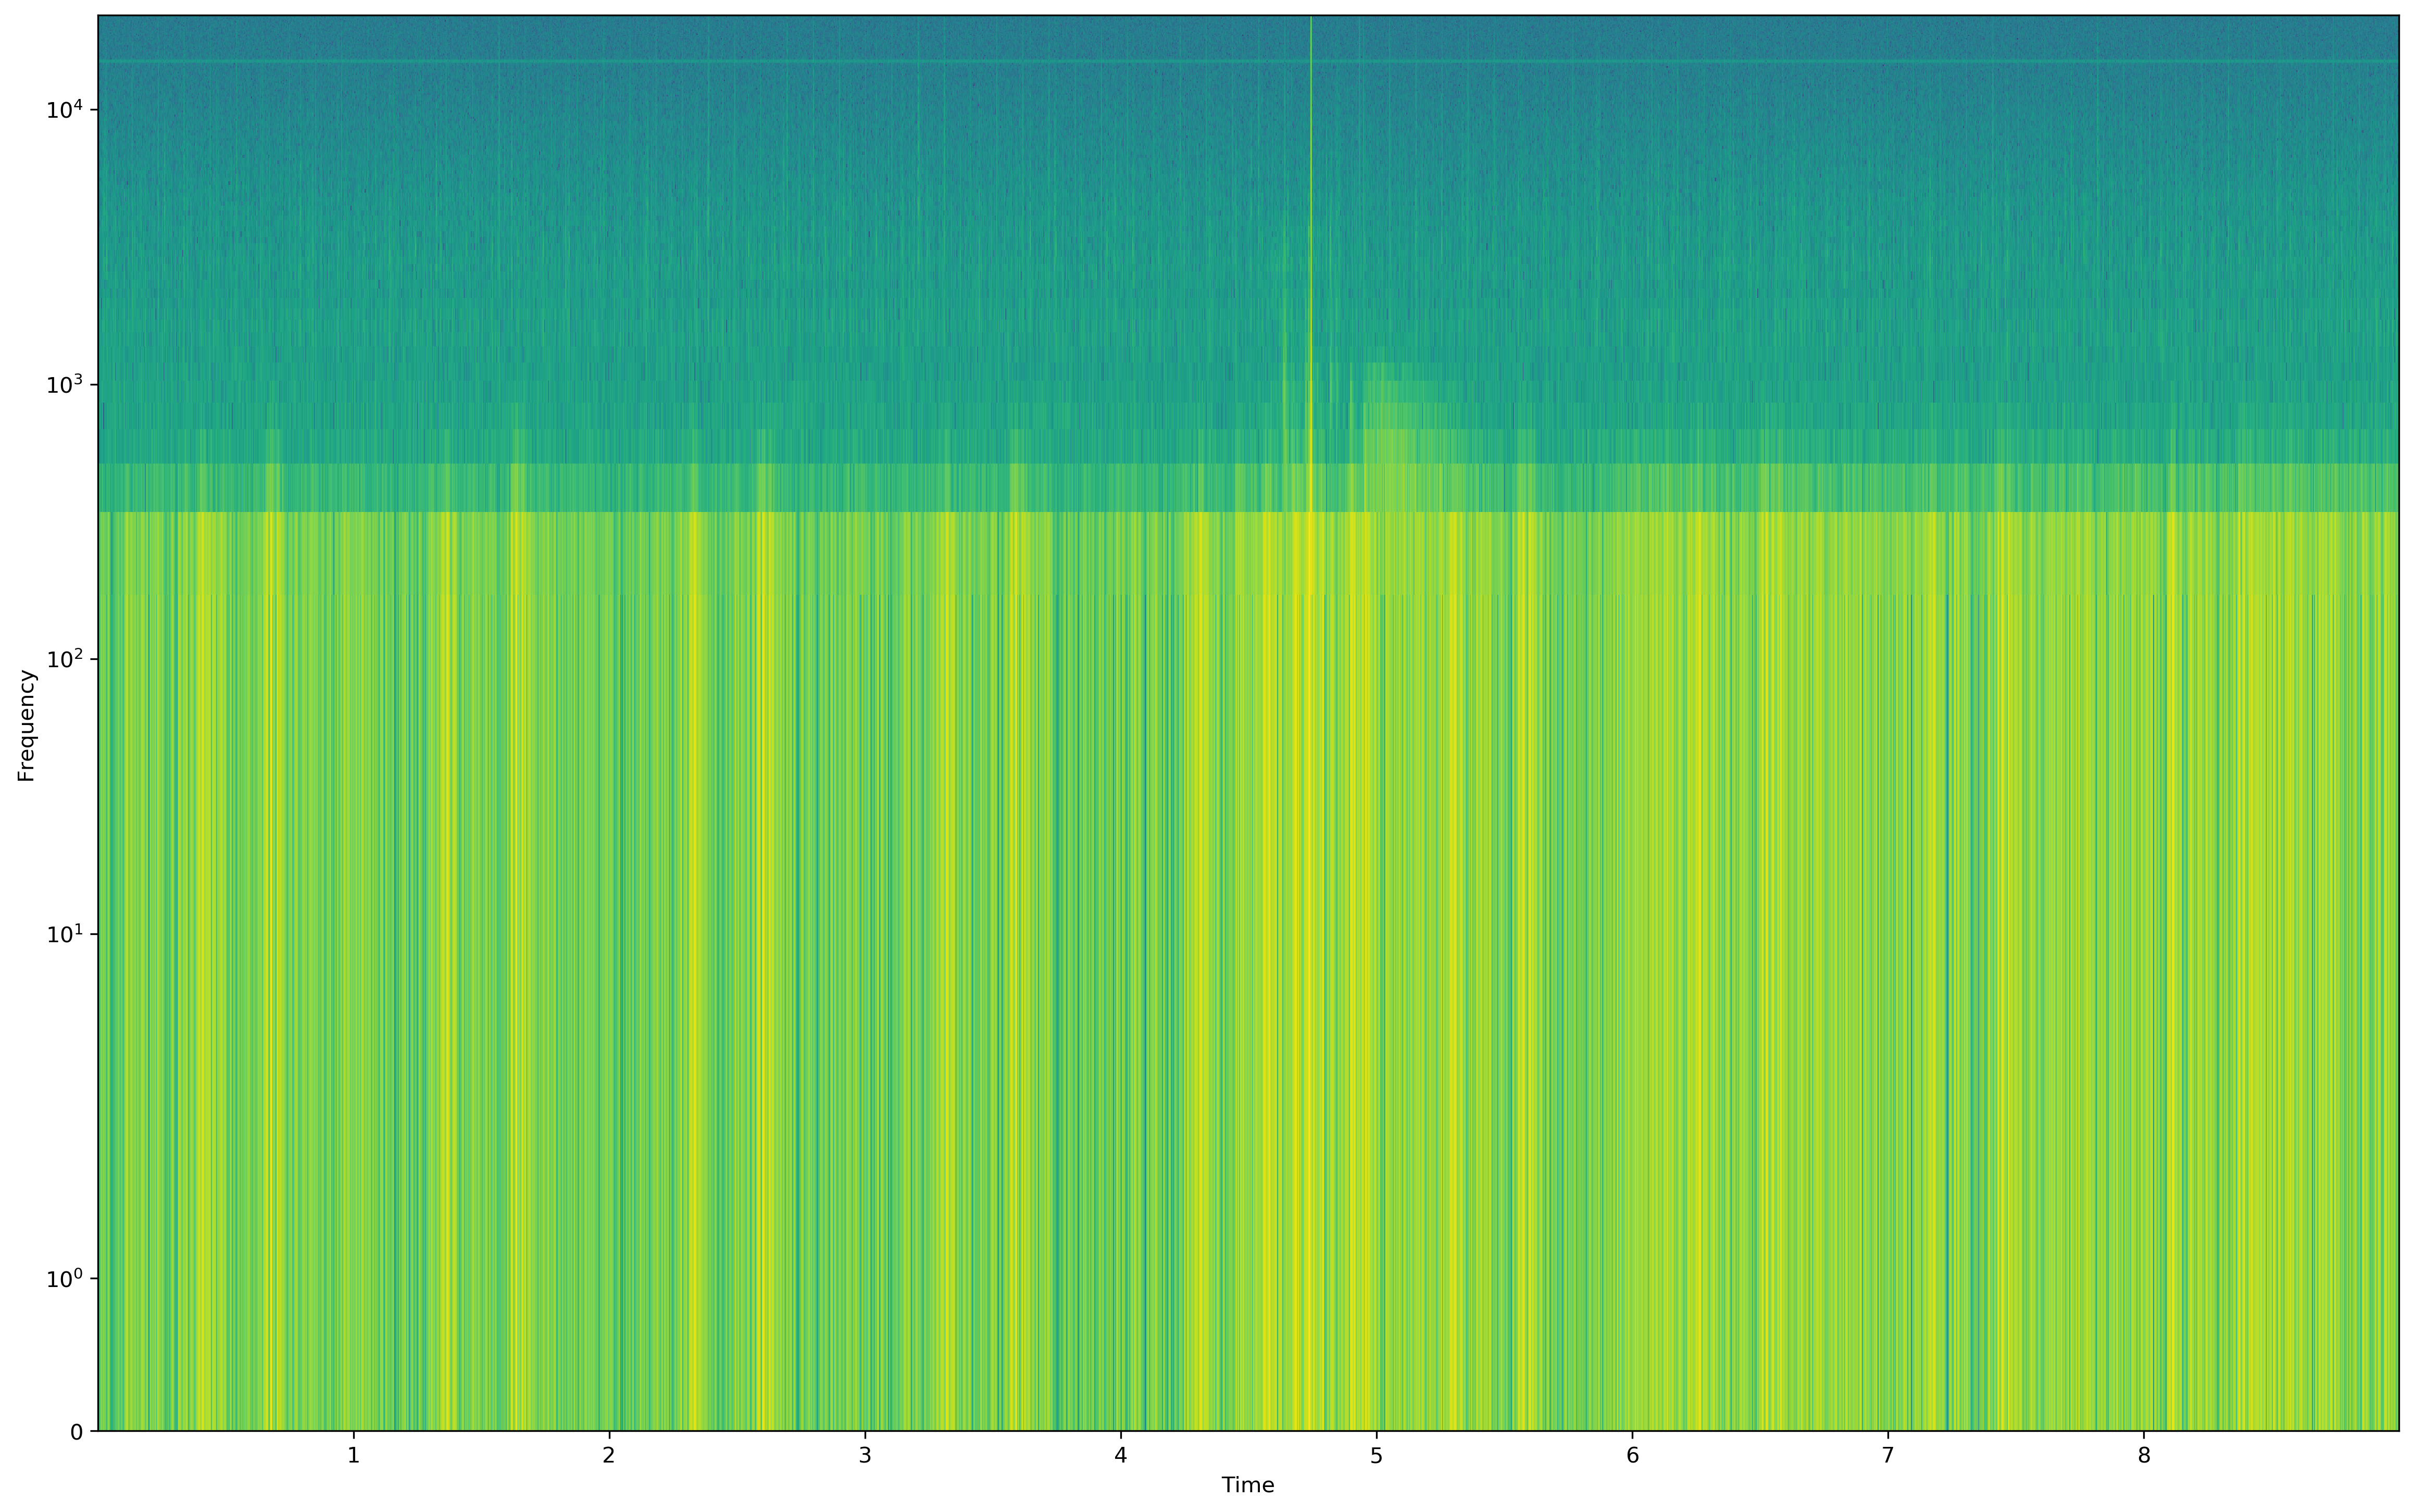

In [197]:
import matplotlib.pyplot as plot
from scipy.io import wavfile

samplingFrequency, signalData = wavfile.read('/Users/admin/Desktop/ML-heart-beat/heartbeat-sounds/set_a/normal__201101151127.wav')

plot.figure(num=None, figsize=(19, 12), dpi=300)
plot.subplot(111)

plot.specgram(signalData,Fs=samplingFrequency)

plot.xlabel('Time')

plot.ylabel('Frequency')
plt.yscale('symlog')
plot.savefig('things.png')
plot.show()

<p>Came across this code that I then made into logarithmic scale and it worked a lot better</p>

In [12]:
import os
import wave
import pylab
import numpy as np
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from numpy.lib import stride_tricks

""" short time fourier transform of audio signal """
def stft(sig, frameSize, overlapFac=0.5, window=np.hanning):
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))

    # zeros at beginning (thus center of 1st window should be for sample nr. 0)   
    samples = np.append(np.zeros(int(np.floor(frameSize/2.0))), sig)    
    # cols for windowing
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))

    frames = stride_tricks.as_strided(samples, shape=(int(cols), frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win

    return np.fft.rfft(frames)    

""" scale frequency axis logarithmically """    
def logscale_spec(spec, sr=44100, factor=20.):
    timebins, freqbins = np.shape(spec)

    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale))

    # create spectrogram with new freq bins
    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):        
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,int(scale[i]):], axis=1)
        else:        
            newspec[:,i] = np.sum(spec[:,int(scale[i]):int(scale[i+1])], axis=1)

    # list center freq of bins
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[int(scale[i]):])]
        else:
            freqs += [np.mean(allfreqs[int(scale[i]):int(scale[i+1])])]

    return newspec, freqs

""" plot spectrogram"""
def plotstft(audiopath, binsize=2**10, plotpath='things', colormap="jet"):
    
    #samplerate, samples = wav.read(audiopath)

    #s = stft(samples, binsize)

    #sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)

    #ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel

    #timebins, freqbins = np.shape(ims)

    #print("timebins: ", timebins)
    #print("freqbins: ", freqbins)

    #plt.figure(figsize=(15, 7.5))
    #plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="bicubic")
    #plt.colorbar()

    
    #plt.xlabel("time (s)")
    #plt.ylabel("frequency (hz)")
    #plt.xlim([0, timebins-1])
    #plt.ylim([0, freqbins])
    
    #plt.axis('off')
    #plt.yscale('symlog')
    

    #xlocs = np.float32(np.linspace(0, timebins-1, 5))
    #plt.xticks(xlocs, ["%.02f" % l for l in ((xlocs*len(samples)/timebins)+(0.5*binsize))/samplerate])
    #ylocs = np.int16(np.round(np.linspace(0, freqbins-1, 10)))
    #plt.yticks(ylocs, ["%.02f" % freq[i] for i in ylocs])
    
    #####
    for j in range(len(os.listdir(audiopath))):

        # gets the j'th file's name from the directory
        directory_name = os.listdir(audiopath)[j]


        if(directory_name != ".DS_Store"):
            for k in range(len(os.listdir(audiopath + directory_name ))):

                if (os.listdir('/Users/admin/Desktop/datasetwav/' + directory_name + "/")[k] != ".DS_Store" ):
                    file_name = os.listdir(audiopath + directory_name )[k]

                    samplerate, samples = wav.read(audiopath + directory_name + "/" + file_name)

                    file_name = file_name[:-4]


                    s = stft(samples, binsize)

                    sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)

                    ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel

                    timebins, freqbins = np.shape(ims)


                    plt.figure(figsize=(15, 7.5))
                    plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="bicubic")

                    plt.axis('off')
                    plt.yscale('symlog')


                    #plt.savefig(directory_name + str(k), bbox_inches="tight")
                    
                    #clears the entire current figure with all its axes,
                    #but leaves the window opened, such that it may be reused for other plots.
                    plt.clf()


    #####
    
    #plt.show()
    
    

    return ims

ims = plotstft('/Users/admin/Desktop/datasetwav/')

            


/Users/admin/Desktop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<p>Now I will be taking this image and applying more preprocessing to split it into intervals to increase
my dataset.</p>

In [2]:
import os, os.path
from pydub import AudioSegment
from pydub.utils import make_chunks

oneSecond = 1000 # 1 represents a milisecond

lengthOfCuts = .75*oneSecond # average heart rate is around 80 beats per minute, which is a heart beat every .75 scnds

#for j in range(len(os.listdir('/Users/admin/Desktop/datasetwav'))):
    
    # gets the j'th file's name from the directory
    directory_name = os.listdir('/Users/admin/Desktop/datasetwav/')[j]
    
    if(directory_name != ".DS_Store"):
        for k in range(len(os.listdir('/Users/admin/Desktop/datasetwav' + "/" + directory_name ))):
            # gets the j'th file's name from the directory

            # gets the j'th audio file within that file
            file_name = os.listdir('/Users/admin/Desktop/datasetwav/' + directory_name )[j]

            # Load into PyDub
            audio = AudioSegment.from_wav('/Users/admin/Desktop/datasetwav/' + directory_name + "/"+ file_name)

            #Takes the audio and cuts it every .75 seconds
            section = make_chunks(audio, lengthOfCuts)

            #save chunks into their own audio files
            #for i, section in enumerate(section):
                section_name = directory_name + "{0}_part{1}.wav".format(k, i)
                print("exporting", section_name)
                section.export(section_name, format="wav")

IndentationError: unexpected indent (<ipython-input-2-298bedb39bd0>, line 12)

In [30]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = '/Users/admin/desktop/datasetwav_img/AtrainingTestNormalMurmurExtrahlArtifact'
TEST_DIR =  '/Users/admin/desktop/physionet_img/atraining_normal_img'
IMG_SIZE_X = 128
IMG_SIZE_Y = 128
LR = 1e-3

MODEL_NAME = 'normalvsmurmur-{}-{}.model'.format(LR,'conv')

def label_img(img):
    word_label = img[10:16]
    #normal lub dubs
#    if word_label == 'normal': return[1,0]
#    elif word_label == 'murmur':return[0,1]
    
    if word_label == 'normal': return[1,0,0,0]
    #problem with 1 or multipl heart valves not closing properly
    elif word_label == 'murmur':return[0,1,0,0]
    #extrasystoles a heartbeat outside the normal rhythm, as often occurs in normal individuals
    elif word_label == 'extrah':return[0,0,1,0]
    #artifacts, can be any random background noise
    elif word_label == 'artifa':return[0,0,0,1]
    
    
def create_train_data():
    training_data = []
    
    for img in tqdm(os.listdir(TRAIN_DIR)):
        if(img != '.DS_Store'):
            label = label_img(img)
            path = os.path.join(TRAIN_DIR, img)
            #img = cv2.resize(cv2.imread(path, cv2.IMREAD_ANYDEPTH), (IMG_SIZE, IMG_SIZE))
            img = cv2.resize(cv2.imread(path), (IMG_SIZE_Y, IMG_SIZE_X))
            training_data.append([np.array(img), np.array(label)])
        
        
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

def process_test_data():
    testing_data = []
     
    for img in tqdm(os.listdir(TEST_DIR)):
        if(img != '.DS_Store'):
            label = label_img(img)
            img_num = img[16:].split('.')[0]
            path = os.path.join(TEST_DIR, img)
            
            img = cv2.resize(cv2.imread(path), (IMG_SIZE_Y, IMG_SIZE_X))
            testing_data.append([np.array(img), img_num])
        
    np.save('test_data.npy', testing_data)
    return testing_data


train_data = create_train_data()
test_data = process_test_data()

100%|██████████| 117/117 [00:00<00:00, 120.11it/s]


In [31]:
import tensorflow
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression


tensorflow.reset_default_graph()


convnet = input_data(shape=[None, IMG_SIZE_Y, IMG_SIZE_X, 3], name = 'input')
print(convnet)

convnet = conv_2d(convnet, 32, 2, activation = 'relu' )
convnet = max_pool_2d(convnet, 2)
print(convnet)

convnet = conv_2d(convnet, 64, 2, activation = 'relu' )
convnet = max_pool_2d(convnet, 2)
print(convnet)

convnet = conv_2d(convnet, 64, 2, activation = 'relu' )
convnet = max_pool_2d(convnet, 2)
print(convnet)

convnet = conv_2d(convnet, 64, 2, activation = 'relu' )
convnet = max_pool_2d(convnet, 2)
print(convnet)

convnet = conv_2d(convnet, 64, 2, activation = 'relu' )
convnet = max_pool_2d(convnet, 2)
print(convnet)

convnet = conv_2d(convnet, 64, 2, activation = 'relu' )
convnet = max_pool_2d(convnet, 2)
print(convnet)

convnet = conv_2d(convnet, 64, 2, activation = 'relu' )
convnet = max_pool_2d(convnet, 2)
print(convnet)

convnet = conv_2d(convnet, 64, 2, activation = 'relu' )
convnet = max_pool_2d(convnet, 2)
print(convnet)



convnet = fully_connected(convnet, 1024, activation = 'sigmoid')
convnet = dropout(convnet, 0.8)
#print(convnet)

convnet = fully_connected(convnet, 4, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')
print(convnet)

model = tflearn.DNN(convnet, tensorboard_dir='log')


if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')
   



Tensor("input/X:0", shape=(?, 128, 128, 3), dtype=float32)
Tensor("MaxPool2D/MaxPool:0", shape=(?, 64, 64, 32), dtype=float32)
Tensor("MaxPool2D_1/MaxPool:0", shape=(?, 32, 32, 64), dtype=float32)
Tensor("MaxPool2D_2/MaxPool:0", shape=(?, 16, 16, 64), dtype=float32)
Tensor("MaxPool2D_3/MaxPool:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("MaxPool2D_4/MaxPool:0", shape=(?, 4, 4, 64), dtype=float32)
Tensor("MaxPool2D_5/MaxPool:0", shape=(?, 2, 2, 64), dtype=float32)
Tensor("MaxPool2D_6/MaxPool:0", shape=(?, 1, 1, 64), dtype=float32)
Tensor("MaxPool2D_7/MaxPool:0", shape=(?, 1, 1, 64), dtype=float32)
Tensor("FullyConnected_1/Softmax:0", shape=(?, 4), dtype=float32)


In [32]:


train = train_data[:-12]
test = train_data[-12:]


#.reshape(-1,IMG_SIZE_Y,IMG_SIZE_X,1)
X = np.array([i[0] for i in train])
Y = [i[1] for i in train]
#.reshape(-1,IMG_SIZE_Y,IMG_SIZE_X,1)
test_x = np.array([i[0] for i in test])
test_y = [i[1] for i in test]


model.fit(X, Y, n_epoch=300, validation_set=(test_x, test_y), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)


Training Step: 599  | total loss: 0.41863 | time: 0.686s
| Adam | epoch: 300 | loss: 0.41863 - acc: 0.9065 -- iter: 064/112
Training Step: 600  | total loss: 0.39217 | time: 2.345s
| Adam | epoch: 300 | loss: 0.39217 - acc: 0.9138 | val_loss: 0.89826 - val_acc: 0.7500 -- iter: 112/112
--


In [29]:
from numpy import array
count = 0

for img in os.listdir(TEST_DIR):
    image = array((test_data[count])[0]).reshape(-1, IMG_SIZE_Y, IMG_SIZE_X, 3)

    prediction = model.predict(image)
    
    ## use this when we know what the image actually is
    #print((test_data[count])[1])
    
    
    print(img)
    print(prediction)
    print(" ")
    
    count+=1



atraining_normal_5.png
[[0.0622022  0.02679623 0.01231017 0.89869136]]
 
atraining_normal_79.png
[[0.05909773 0.02881506 0.00934971 0.9027375 ]]
 
atraining_normal_45.png
[[0.21465316 0.02447617 0.0141326  0.746738  ]]
 
atraining_normal_51.png
[[0.08828552 0.02746009 0.00763769 0.87661666]]
 
atraining_normal_86.png
[[0.04716593 0.02998898 0.01163173 0.91121334]]
 
atraining_normal_92.png
[[0.0881852  0.02602713 0.00833736 0.87745035]]
 
atraining_normal_93.png
[[0.04885414 0.02843645 0.01149172 0.9112177 ]]
 
atraining_normal_87.png
[[0.13164206 0.02537887 0.01105954 0.8319195 ]]
 
atraining_normal_50.png
[[0.09595384 0.02649646 0.00728939 0.8702603 ]]
 
atraining_normal_44.png
[[0.06747364 0.02576623 0.01357512 0.893185  ]]
 
atraining_normal_78.png
[[0.06647654 0.02688295 0.01617859 0.8904619 ]]
 
atraining_normal_4.png
[[0.05662733 0.02837978 0.00972884 0.9052641 ]]
 
atraining_normal_6.png
[[0.19611278 0.02512067 0.00658029 0.7721862 ]]
 
atraining_normal_52.png
[[0.22390912 0.02

In [ ]:
#model.save(MODEL_NAME)
#tensorboard --logdir=/Users/admin/Desktop/ML-heart-beat/log

In [43]:
import matplotlib.pyplot as plt

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # normal: [1,0]
    # murmur: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    print("num: " + str(img_num) + " data: " + str(img_data) )
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE_Y,IMG_SIZE_X,1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Abnormal'
    else: str_label='normal'
        
    y.imshow(orig,cmap='jet')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U13'), dtype('<U13')) -> dtype('<U13')

<Figure size 432x288 with 0 Axes>

In [1]:
import os
audiopath = '/Users/admin/Desktop/datasetwav/'


for j in range(len(os.listdir(audiopath))):

    # gets the j'th file's name from the directory
    directory_name = os.listdir(audiopath)[j]

    i = 0

    if(directory_name != ".DS_Store"):

        for file_name in os.listdir(audiopath + directory_name):

            if (file_name != ".DS_Store" ):

                total_path = audiopath + directory_name +"/" + file_name

                #os.rename(total_path, directory_name+str(i)+'.wav')

                print(directory_name + str(i))

                i+=1
        

            
            



Btraining_noisymurmur0
Btraining_noisymurmur1
Btraining_noisymurmur2
Btraining_noisymurmur3
Btraining_noisymurmur4
Btraining_noisymurmur5
Btraining_noisymurmur6
Btraining_noisymurmur7
Btraining_noisymurmur8
Btraining_noisymurmur9
Btraining_noisymurmur10
Btraining_noisymurmur11
Btraining_noisymurmur12
Btraining_noisymurmur13
Btraining_noisymurmur14
Btraining_noisymurmur15
Btraining_noisymurmur16
Btraining_noisymurmur17
Btraining_noisymurmur18
Btraining_noisymurmur19
Btraining_noisymurmur20
Btraining_noisymurmur21
Btraining_noisymurmur22
Btraining_noisymurmur23
Btraining_noisymurmur24
Btraining_noisymurmur25
Btraining_noisymurmur26
Btraining_noisymurmur27
Btraining_noisymurmur28
Btraining_noisynormal0
Btraining_noisynormal1
Btraining_noisynormal2
Btraining_noisynormal3
Btraining_noisynormal4
Btraining_noisynormal5
Btraining_noisynormal6
Btraining_noisynormal7
Btraining_noisynormal8
Btraining_noisynormal9
Btraining_noisynormal10
Btraining_noisynormal11
Btraining_noisynormal12
Btraining_no

In [23]:
directory_name = os.listdir('/Users/admin/Desktop/datasetwav/')[2]
i = 0
for file in os.listdir(audiopath + directory_name ):
    
    #directory_name2 = os.listdir('/Users/admin/Desktop/datasetwav/')[i]
    i += 1

    if(file != '.DS_Store' ):
        print(file + str(i))


164_1307106095995_C.wav1
240_1309196119795_C.wav2
116_1306258689913_A.wav3
242_1309197394064_B.wav4
254_1309350589009_C.wav5
240_1309196119795_B.wav6
164_1307106095995_B.wav7
254_1309350589009_A.wav8
292_1311185449649_B.wav9
116_1306258689913_C.wav10
292_1311185449649_C.wav11
211_1308163238707_C.wav12
254_1309350589009_D.wav13
242_1309197394064_D.wav15
156_1306936373241_B.wav16
116_1306258689913_D.wav17
200_1308144251434_D.wav18
293_1311680805936_B1.wav19
171_1307971016233_D.wav20
171_1307971016233_E.wav21
185_1308073325396_B.wav22
185_1308073325396_C.wav23
240_1309201366049_B.wav24
193_1308078104592_C1.wav25
200_1308144251434_C.wav26
171_1307971016233_D1.wav27
245_1309200438094_B.wav28
276_1311162716489_C.wav29
281_1311165683454_D.wav30
203_1308162026258_B.wav31
288_1311164615284_D.wav32
165_1307109069581_C2.wav33
287_1311170903290_C.wav34
161_1307101199321_A.wav35
204_1308159229275_B.wav36
281_1311165683454_A.wav37
195_1308140095331_C.wav38
254_1309350589009_A1.wav39
195_130814009533

In [76]:
#  cv::IMREAD_UNCHANGED = -1, 
#  cv::IMREAD_GRAYSCALE = 0, 
#  cv::IMREAD_COLOR = 1, 
#  cv::IMREAD_ANYDEPTH = 2, 
#  cv::IMREAD_ANYCOLOR = 4, 
#  cv::IMREAD_LOAD_GDAL = 8, 
#  cv::IMREAD_REDUCED_GRAYSCALE_2 = 16, 
#  cv::IMREAD_REDUCED_COLOR_2 = 17, 
#  cv::IMREAD_REDUCED_GRAYSCALE_4 = 32, 
#  cv::IMREAD_REDUCED_COLOR_4 = 33, 
#  cv::IMREAD_REDUCED_GRAYSCALE_8 = 64, 
#  cv::IMREAD_REDUCED_COLOR_8 = 65, 
#  cv::IMREAD_IGNORE_ORIENTATION = 128 
 
from PIL import Image  
string = "stuffandthings"


x = cv2.IMREAD_COLOR
y = cv2.IMREAD_GRAYSCALE
z = cv2.IMREAD_UNCHANGED

for img in tqdm(os.listdir(TEST_DIR)):
    
        label = label_img(img)
        path = os.path.join(TEST_DIR, img)
        ####
        
        
        
        im = cv2.resize(cv2.imread(path, z), ( IMG_SIZE, IMG_SIZE))
im = Image.open(path)
im.show()
print(string[:-4])
print(string[-4:])


print(cv2.imread(path, 8).size)      
print(cv2.imread(path,y))

#print(im[25])
        



100%|██████████| 52/52 [00:00<00:00, 120.88it/s]


stuffandth
ings
1436488
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


In [5]:
import tensorflow
print(tensorflow.__version__)

1.14.0


In [9]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
#use this for audio that people send me, single use

import os
import wave
import pylab
import numpy as np
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from numpy.lib import stride_tricks

binsize=2**10
plotpath='things'
colormap="jet"

""" short time fourier transform of audio signal """
def stft(sig, frameSize, overlapFac=0.5, window=np.hanning):
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))

    # zeros at beginning (thus center of 1st window should be for sample nr. 0)   
    samples = np.append(np.zeros(int(np.floor(frameSize/2.0))), sig)    
    # cols for windowing
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))

    frames = stride_tricks.as_strided(samples, shape=(int(cols), frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win

    return np.fft.rfft(frames)    

""" scale frequency axis logarithmically """    
def logscale_spec(spec, sr=44100, factor=20.):
    timebins, freqbins = np.shape(spec)

    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale))

    # create spectrogram with new freq bins
    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):        
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,int(scale[i]):], axis=1)
        else:        
            newspec[:,i] = np.sum(spec[:,int(scale[i]):int(scale[i+1])], axis=1)

    # list center freq of bins
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[int(scale[i]):])]
        else:
            freqs += [np.mean(allfreqs[int(scale[i]):int(scale[i+1])])]

    return newspec, freqs



file_name = '/Users/admin/desktop/ML-heart-beat/heartbeat-sounds/stuff/nicoheartbeat.wav'

samplerate, samples = wav.read(file_name)

file_name = file_name[:-4]


s = stft(samples, binsize)

sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)

ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel

timebins, freqbins = np.shape(ims)


plt.figure(figsize=(15, 7.5))
plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="bicubic")

plt.axis('off')
plt.yscale('symlog')


plt.savefig('nicoHeartBeatGraph', bbox_inches="tight")

#clears the entire current figure with all its axes,
#but leaves the window opened, such that it may be reused for other plots.
plt.clf()

/Users/admin/Desktop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: WavFileWarning: Reached EOF prematurely; finished at 2947180 bytes, expected 2947188 bytes from header.
/Users/admin/Desktop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in log10


<Figure size 1080x540 with 0 Axes>

In [37]:
print("safasdfasdf:    " + str(layer1.trainable))
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights
layer.trainable = False  # Freeze the layer

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

##

# Make a model with 2 layers
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])
# Freeze the first layer
layer1.trainable = False

# Keep a copy of the weights of layer1 for later reference
initial_layer1_weights_values = layer1.get_weights()

# Train the model
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# Check that the weights of layer1 have not changed during training
final_layer1_weights_values = layer1.get_weights()
np.testing.assert_allclose(
    initial_layer1_weights_values[0], final_layer1_weights_values[0]
)
np.testing.assert_allclose(
    initial_layer1_weights_values[1], final_layer1_weights_values[1]
)




safasdfasdf:    False
weights: 2
trainable_weights: 0
non_trainable_weights: 2
2/2 [==============================] - 0s 60ms/sample - loss: 0.1227
